In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/test123/c446dacd-619f-4d32-9247-23dcda1198c5.JPG
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/inp

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import numpy as np
%matplotlib inline

In [3]:
import keras.backend as K
from keras.models import Model, Sequential 
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization 
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam 
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping 
import tensorflow as tf
import cv2

Using TensorFlow backend.


In [4]:
#setting a seed value to get the same result while re-running the code.
seed = 123
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
print(os.listdir("../input"))

['test123', 'chest-xray-pneumonia']


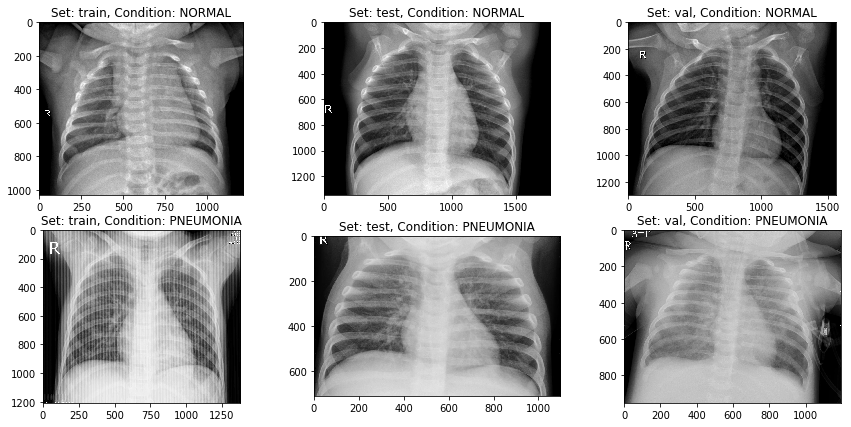

In [6]:
#Looking at a few non-infected and infected X-rays from the three directories that is test, train, validation.
input_path = '../input/chest-xray-pneumonia/chest_xray/'
fig, ax = plt.subplots(2,3, figsize=(15,7))
ax = ax.ravel()
plt.tight_layout

for i, _set in enumerate(['train','test','val']):
    set_path = input_path + _set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[2]),cmap = 'gray')
    ax[i].set_title('Set: {}, Condition: NORMAL'.format(_set))
    ax[i+3].imshow(plt.imread(set_path + '/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA')[2]),cmap = 'gray')
    ax[i+3].set_title('Set: {}, Condition: PNEUMONIA'.format(_set))

In [7]:
# Dividing the dataset into 3 sets i.e., Test, Train and Validation
total = 0
for _set in ['test','train','val']:
    normal = len(os.listdir(input_path +'/'+ _set + '/NORMAL'))
    infected = len(os.listdir(input_path +'/'+ _set + '/PNEUMONIA'))
    print('Set: {}, Normal images: {}, Pneumonia images: {}'.format(_set,normal,infected))
    total = total + normal + infected
print("Total images: ",total)

Set: test, Normal images: 234, Pneumonia images: 390
Set: train, Normal images: 1341, Pneumonia images: 3875
Set: val, Normal images: 8, Pneumonia images: 8
Total images:  5856


In [8]:
# Data Augmentation, feeding the test and training set images to the network and creating labels for images
def process_data(img_dims, batch_size):
    # Data generations objects for train and test,validation
    train_datagen = ImageDataGenerator(zoom_range = 0.3, horizontal_flip= True, rescale = 1./255)
    test_val_datagen = ImageDataGenerator(rescale = 1./255)

    # Feeding this to the network in specific dimensions and batch size
    train_gen = train_datagen.flow_from_directory(
        directory = input_path + '/' + 'train',
        target_size = (img_dims, img_dims),
        batch_size= batch_size,
        class_mode = 'binary',
        shuffle = True)
    test_gen = test_val_datagen.flow_from_directory(
        directory = input_path + '/' + 'test',
        target_size = (img_dims, img_dims),
        batch_size = batch_size,
        class_mode = 'binary',
        shuffle = True)
    
    test_data = []
    test_labels = []

    for condition in ['/NORMAL/','/PNEUMONIA/']:
        for img in (os.listdir(input_path + '/' + 'test' + condition)):
            img = plt.imread(input_path + '/' +'test' + condition + img)
            img = cv2.resize(img,(img_dims,img_dims))
            img = np.dstack([img,img,img])
            img = img.astype('float32')/255
            if condition == '/NORMAL/':
                label = 0
            elif condition == '/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)

    test_data = np.array(test_data)
    test_labels = np.array(test_labels)

    return train_gen, test_gen, test_data, test_labels


In [9]:
img_dims = 150
epochs = 10
batch_size = 32

train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [10]:
check = pd.DataFrame(columns = ['Test_Data','Test_Label'])

for i in range(len(test_data)):
    check.loc[i] = [test_data[i],test_labels[i]]
check.head(5)


,Test_Data,Test_Label
0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",0
1,"[[[0.0, 0.0, 0.0], [0.003921569, 0.003921569, ...",0
2,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",0
3,"[[[0.5529412, 0.5529412, 0.5529412], [0.552941...",0
4,"[[[0.03137255, 0.03137255, 0.03137255], [0.019...",0


In [11]:
#Buliding a Sequential Model
inputs = Input(shape = (img_dims,img_dims,3))

#First Convolution Block
x = Conv2D(filters=16, kernel_size = (3,3), activation = 'relu', padding = 'same')(inputs)
x = Conv2D(filters=16, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = MaxPool2D(pool_size=(2,2))(x)

#Second Convolution Block
x = SeparableConv2D(filters = 32, kernel_size=(3,3), activation = 'relu', padding  = 'same')(x)
x = SeparableConv2D(filters = 32, kernel_size=(3,3), activation = 'relu', padding  = 'same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)

#Third Convolution Block
x = SeparableConv2D(filters = 64, kernel_size=(3,3), activation = 'relu', padding  = 'same')(x)
x = SeparableConv2D(filters = 64, kernel_size=(3,3), activation = 'relu', padding  = 'same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)

#Fourth Convolution Block
x = SeparableConv2D(filters = 128, kernel_size=(3,3), activation = 'relu', padding  = 'same')(x)
x = SeparableConv2D(filters = 128, kernel_size=(3,3), activation = 'relu', padding  = 'same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Dropout(rate=0.2)(x)

#Fifth Convolution Block
x = SeparableConv2D(filters = 256, kernel_size=(3,3), activation = 'relu', padding  = 'same')(x)
x = SeparableConv2D(filters = 256, kernel_size=(3,3), activation = 'relu', padding  = 'same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Dropout(rate=0.2)(x)

#FC layers
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

#Output layer
output = Dense(units = 1, activation = 'sigmoid')(x)

#Creating model and compiling
model = Model(input = inputs, output = output)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [12]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 75, 75, 32)        688       
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 75, 75, 32)        1344      
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 32)        128 

In [13]:
len(model.layers)

30

In [14]:
hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=10, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])


Epoch 1/10
163/163 [==============================] - 116s 709ms/step - loss: 0.3834 - accuracy: 0.8255 - val_loss: 0.6090 - val_accuracy: 0.6234
Epoch 2/10
163/163 [==============================] - 85s 524ms/step - loss: 0.2870 - accuracy: 0.8809 - val_loss: 0.7376 - val_accuracy: 0.6267
Epoch 3/10
163/163 [==============================] - 83s 509ms/step - loss: 0.2279 - accuracy: 0.9139 - val_loss: 1.1811 - val_accuracy: 0.6233
Epoch 4/10
163/163 [==============================] - 83s 512ms/step - loss: 0.2124 - accuracy: 0.9201 - val_loss: 0.6502 - val_accuracy: 0.6115
Epoch 5/10
163/163 [==============================] - 82s 505ms/step - loss: 0.2195 - accuracy: 0.9172 - val_loss: 2.4209 - val_accuracy: 0.6402
Epoch 6/10
163/163 [==============================] - 83s 509ms/step - loss: 0.1736 - accuracy: 0.9360 - val_loss: 0.6113 - val_accuracy: 0.8953
Epoch 7/10
163/163 [==============================] - 83s 508ms/step - loss: 0.1750 - accuracy: 0.9348 - val_loss: 0.2159 - val_a

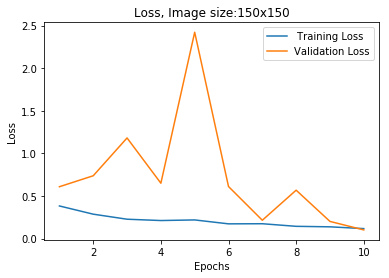

In [15]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1,11)
plt.plot(epochs, loss, label=' Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title(label = ('Loss, Image size:{}x{}'.format(img_dims,img_dims)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

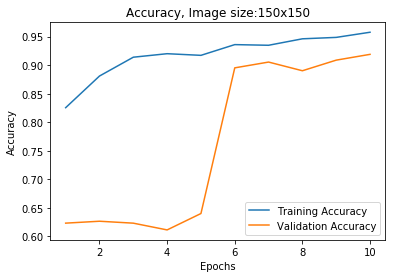

In [16]:
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']
epochs = range(1,11)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title(label = ('Accuracy, Image size:{}x{}'.format(img_dims,img_dims)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

CONFUSION MATRIX 


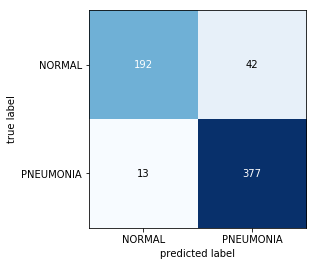


TEST METRICS 
Accuracy: 91.18589743589743%
Precision: 89.97613365155132%
Recall: 96.66666666666667%
F1-score: 93.20148331273178

TRAIN METRIC
Train acc: 95.76


In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()
labels = ['NORMAL','PNEUMONIA']

print('CONFUSION MATRIX ')
#print(cm)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.show()

print('\nTEST METRICS ')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))


In [18]:
model.save('CNN_model.h5')

In [19]:
from keras.models import load_model
from keras.preprocessing import image

def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(img_dims, img_dims))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor


if __name__ == "__main__":

    # load model
    model = load_model("CNN_model.h5")

    # image path
    #img_path = input_path + 'test/PNEUMONIA/'+os.listdir(input_path + 'test/PNEUMONIA')[11] 
    img_path = '../input/test123/c446dacd-619f-4d32-9247-23dcda1198c5.JPG'
   
    new_image = load_image(img_path)

    # check prediction
    pred = model.predict(new_image)
    
    if pred > 0.5:
        print("PNEUMONIA",pred)
    else:
        print("NORMAL",pred)

NORMAL [[0.18334447]]


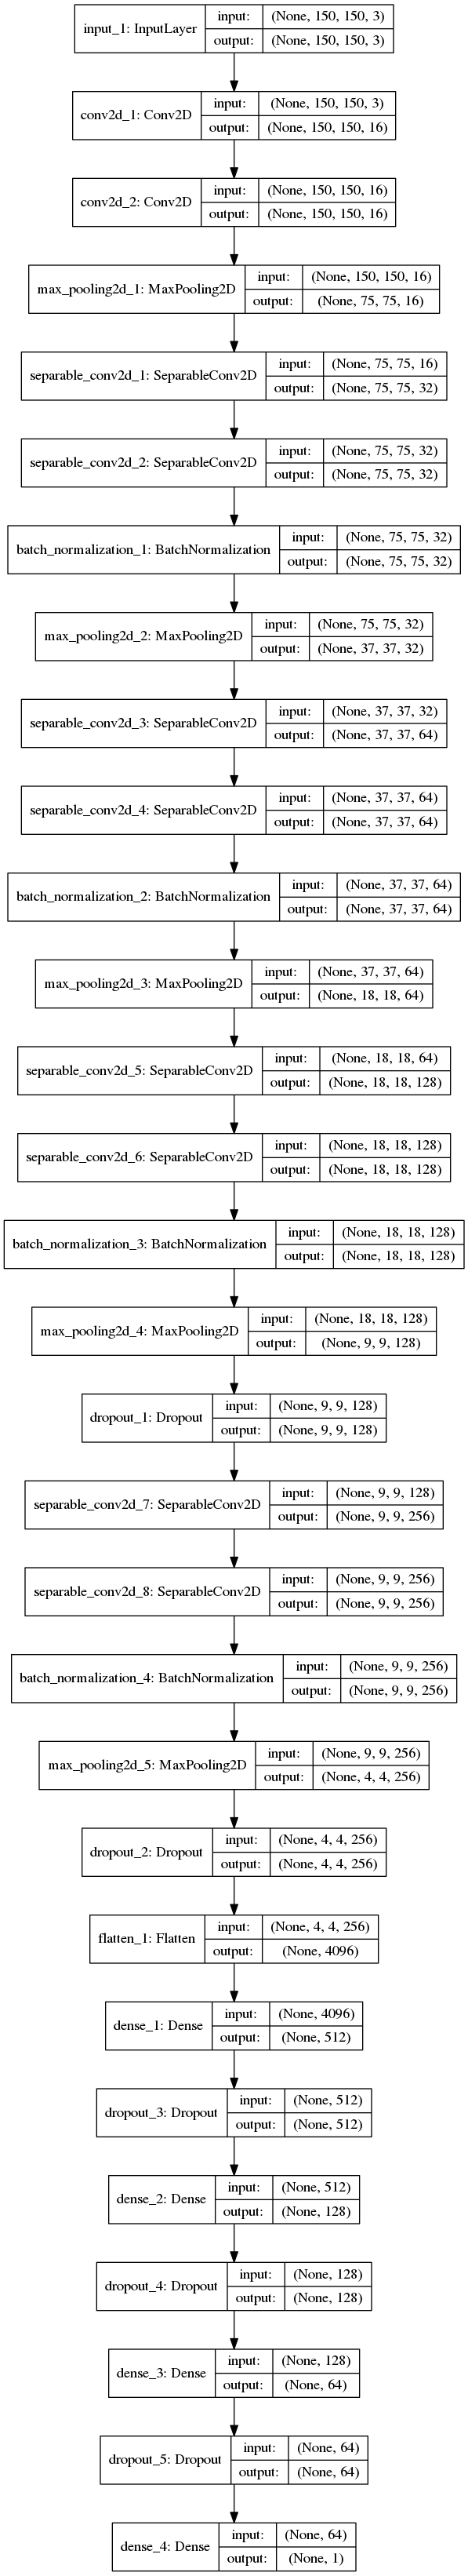

In [20]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
# Save the visualization as a file
plot_model(model, show_shapes=True, to_file='network.png')


In [21]:
import h5py

f = h5py.File("best_weights.hdf5")

list(f)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  This is separate from the ipykernel package so we can avoid doing imports until


['batch_normalization_1',
 'batch_normalization_2',
 'batch_normalization_3',
 'batch_normalization_4',
 'conv2d_1',
 'conv2d_2',
 'dense_1',
 'dense_2',
 'dense_3',
 'dense_4',
 'dropout_1',
 'dropout_2',
 'dropout_3',
 'dropout_4',
 'dropout_5',
 'flatten_1',
 'input_1',
 'max_pooling2d_1',
 'max_pooling2d_2',
 'max_pooling2d_3',
 'max_pooling2d_4',
 'max_pooling2d_5',
 'separable_conv2d_1',
 'separable_conv2d_2',
 'separable_conv2d_3',
 'separable_conv2d_4',
 'separable_conv2d_5',
 'separable_conv2d_6',
 'separable_conv2d_7',
 'separable_conv2d_8']